# Subtask 1

In [1]:
import numpy as np

import keras

import matplotlib.pyplot as plt

In [2]:
def make_network(initialization, activation):  # prepare 10 layers, 500 units each
    layers = [
        keras.layers.Dense(units=500, activation=activation,
                           kernel_initializer=initialization)
        for _ in range(10)
    ]
    return layers

def plot_histograms(x, network):
    plt.figure(figsize=(22, 4))
    for i, layer in enumerate(network):
        x = layer(x)
        plt.subplot(1, 10, i+1)
        plt.hist(x.numpy().ravel(), bins=20)
        plt.xlim([-1.0, 1.0])
        plt.title('Layer {}'.format(i+1))

def make_and_plot(x, initialization, activation):
    plot_histograms(x, make_network(initialization, activation))

In [3]:
X = np.random.randn(1, 500)

## sigmoid

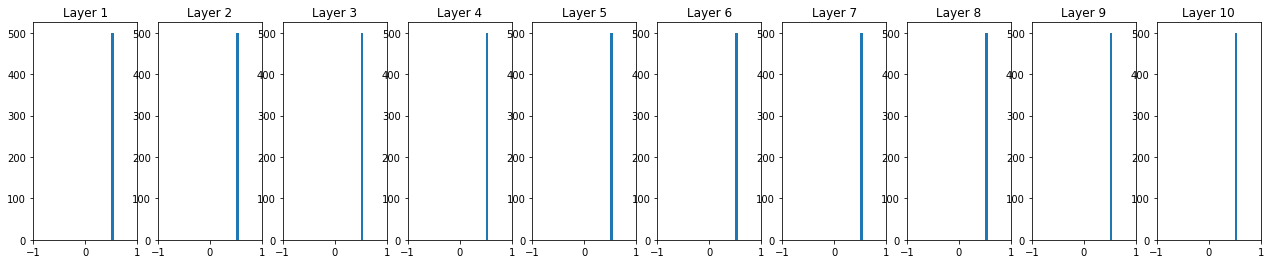

In [4]:
make_and_plot(X, 'zeros', 'sigmoid')

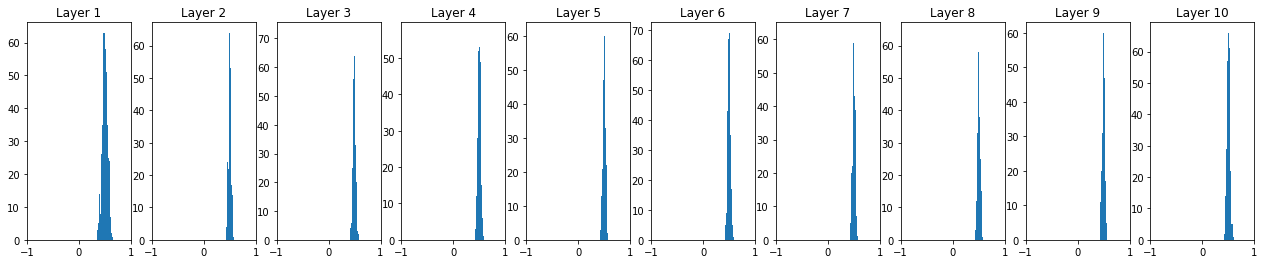

In [5]:
make_and_plot(X, keras.initializers.normal(stddev=0.01), 'sigmoid')

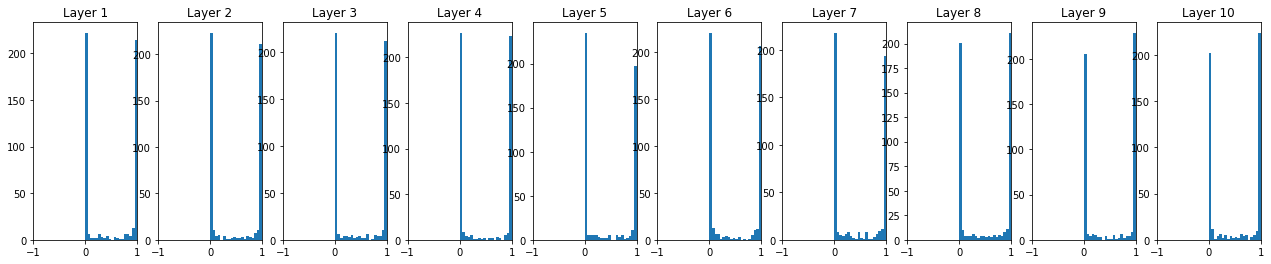

In [6]:
make_and_plot(X, keras.initializers.normal(stddev=1.0), 'sigmoid')

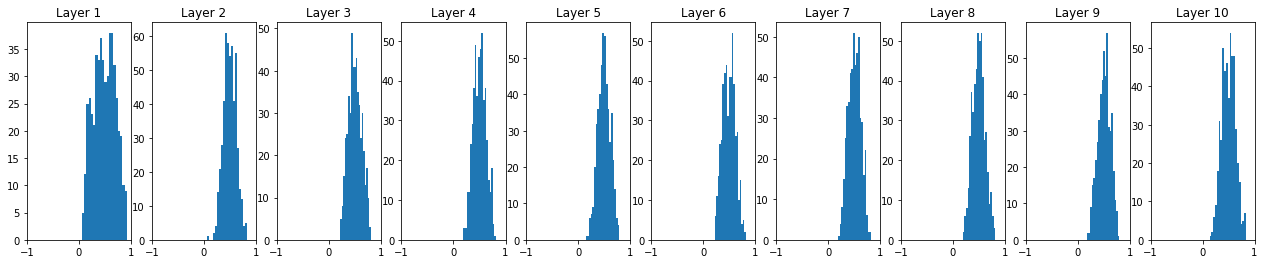

In [7]:
make_and_plot(X, 'glorot_normal', 'sigmoid')  # full name: Xavier Glorot

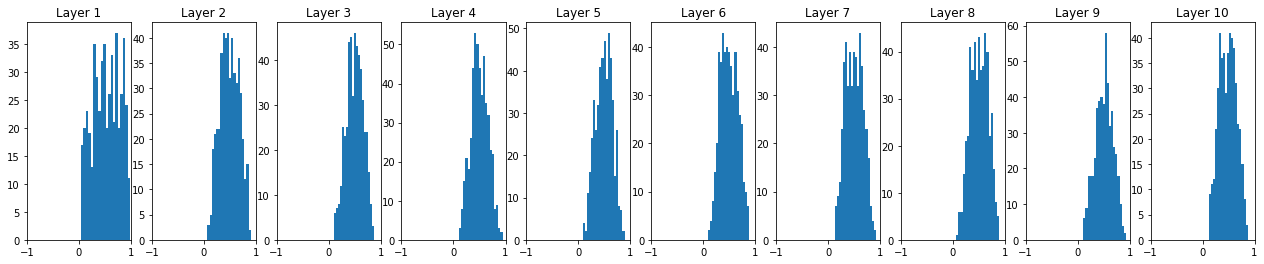

In [8]:
make_and_plot(X, 'he_normal', 'sigmoid')

## tanh

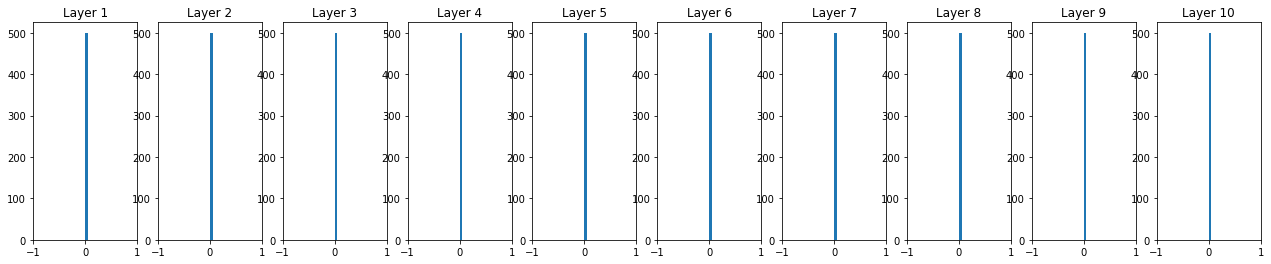

In [9]:
make_and_plot(X, 'zeros', 'tanh')

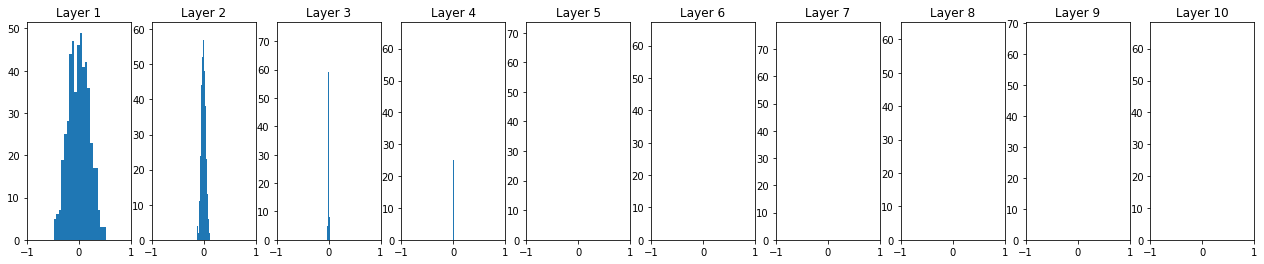

In [10]:
make_and_plot(X, keras.initializers.normal(stddev=0.01), 'tanh')

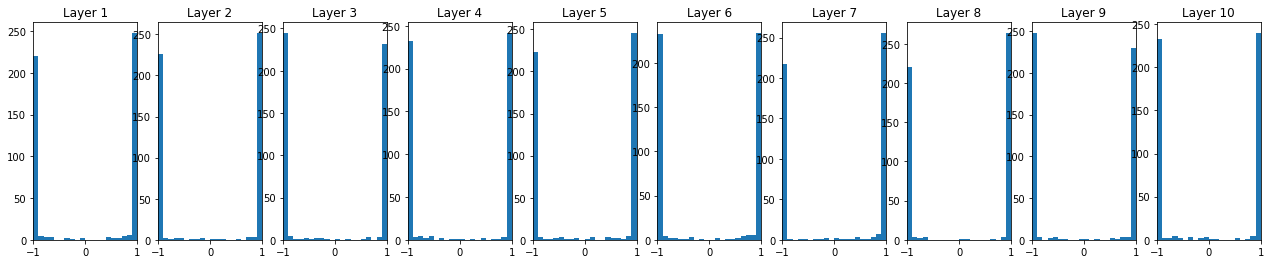

In [11]:
make_and_plot(X, keras.initializers.normal(stddev=1.0), 'tanh')

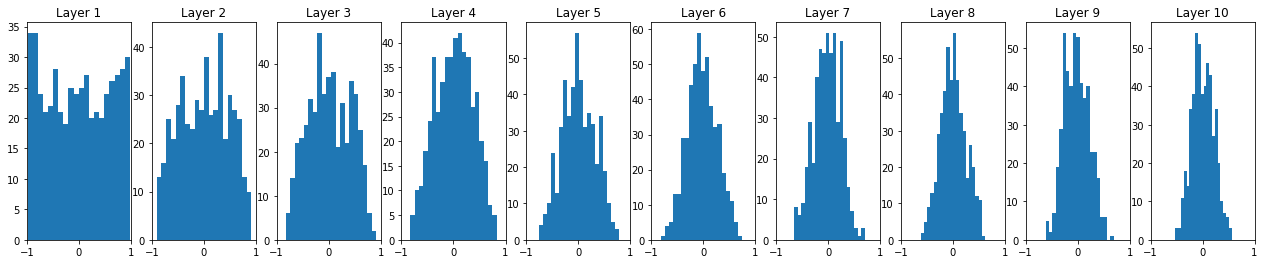

In [12]:
make_and_plot(X, 'glorot_normal', 'tanh')

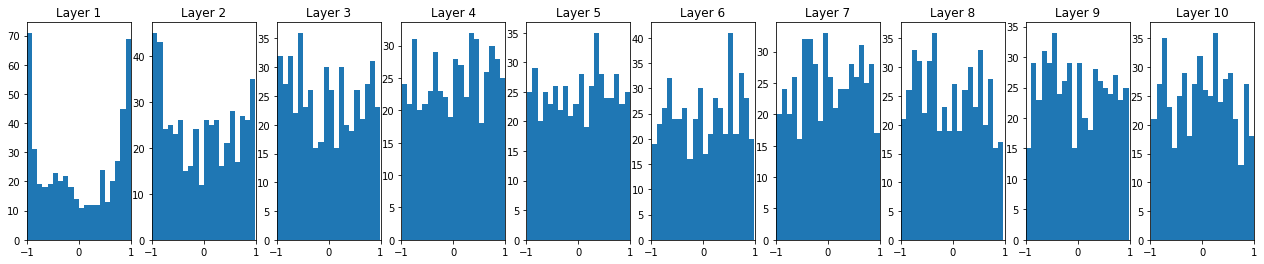

In [13]:
make_and_plot(X, 'he_normal', 'tanh')

## ReLU

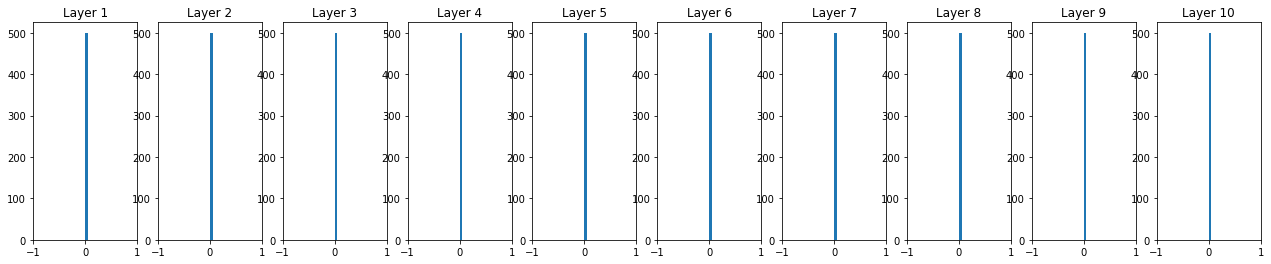

In [14]:
make_and_plot(X, 'zeros', 'relu')

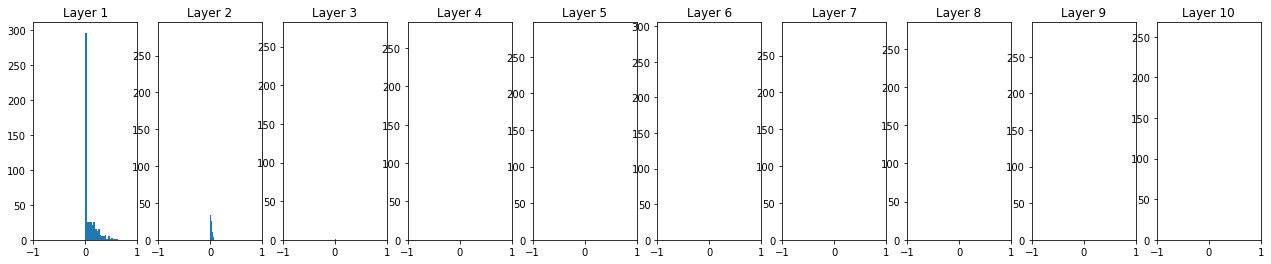

In [15]:
make_and_plot(X, keras.initializers.normal(stddev=0.01), 'relu')

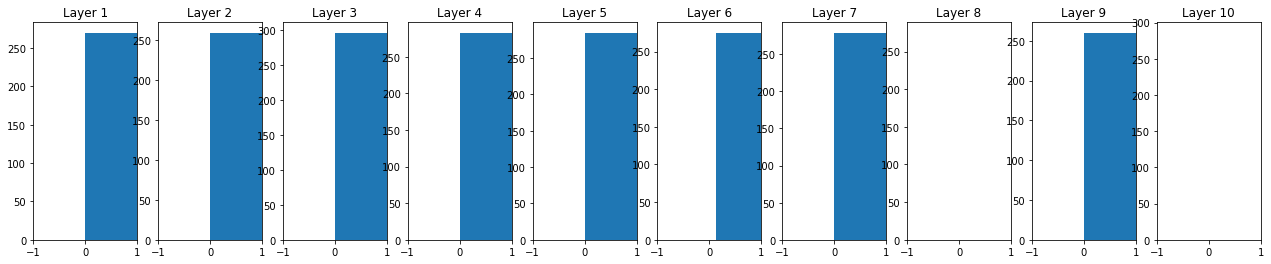

In [16]:
make_and_plot(X, keras.initializers.normal(stddev=1.0), 'relu')

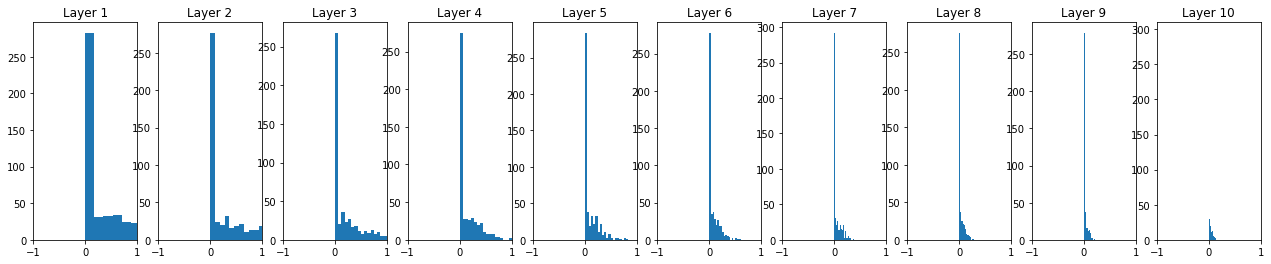

In [17]:
make_and_plot(X, 'glorot_normal', 'relu')

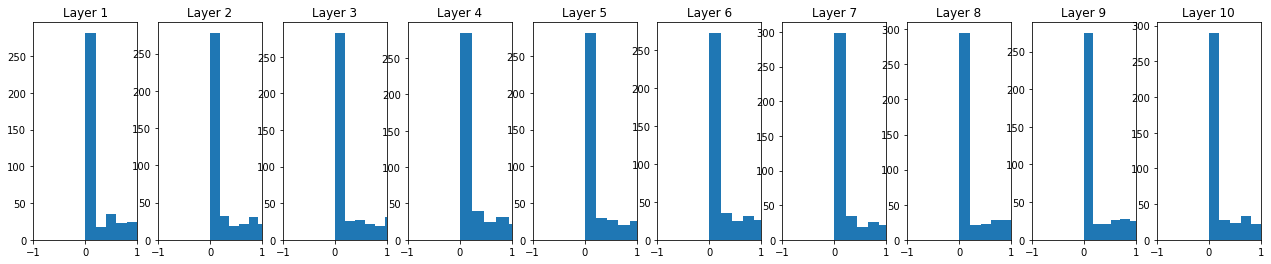

In [18]:
make_and_plot(X, 'he_normal', 'relu')

# Subtask 2

**TASK:**

Neural Networks and Deep Learning
Cracow University of Technology

Lab Assignment 5:

The purpose of this laboratory is to implement a neural network for a classification task:



1.   The network is trained using minibatch stochastic gradient descent.
2.   You have images of handwritten digits from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) and you should train the network to predict the value of the digit for images.

Network specification:

1.   Input layer - one hidden layer - output layer
2.   Activation functions: for hidden layer "ReLU" and for output layer "softmax"
3.   Loss function: categorical cross-entropy



## Data preparation

In [19]:
import os

import gzip

import numpy as np

In [20]:
dataset_path = 'mnist'

test_images_path = os.path.join(dataset_path, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(dataset_path, 't10k-labels-idx1-ubyte.gz')
train_images_path = os.path.join(dataset_path, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(dataset_path, 'train-labels-idx1-ubyte.gz')

In [21]:
def read_dataset(path):
    if 'images' in path:
        elem_size, header_bytes = 28, 16
        type_ = np.float32
    else:
        elem_size, header_bytes = 1, 8
        type_ = np.uint8
        
    if 't10k' in path:
        num = 10000
    else:
        num = 60000
        
    f = gzip.open(path, 'r')
    f.read(header_bytes)
    shape = 1 if elem_size == 1 else (elem_size, elem_size)
    
    return np.array([
        np.frombuffer(f.read(elem_size*elem_size), dtype=np.uint8).
                      astype(type_).
                      reshape(shape)
        for _ in range(num)
    ])

def labels_to_one_hot(array):
    n = array.shape[0]
    res = np.zeros((n, 10))
    res[np.arange(n), array.ravel()] = 1
    return res

In [22]:
X_train = read_dataset(train_images_path).reshape(-1, 784) / 255.
y_train = labels_to_one_hot(read_dataset(train_labels_path))
X_test = read_dataset(test_images_path).reshape(-1, 784) / 255.
y_test = labels_to_one_hot(read_dataset(test_labels_path))

print(f'{X_train.shape = }')
print(f'{y_train.shape = }')
print(f'{X_test.shape = }')
print(f'{y_test.shape = }')

X_train.shape = (60000, 784)
y_train.shape = (60000, 10)
X_test.shape = (10000, 784)
y_test.shape = (10000, 10)


## Network preparation

Since last time the best model was the one that used momentum optimization with momentum coefficient of 0.9, we will build it once again and fit it and compare it with the same model with dropout applied. Only the code that is needed in this exercise is being used in this notebook

Parameters:
- n_hidden_units = 300,
- epochs = 15,
- l_rate = 0.03,
- batch_size = 32.

Since retention probability = 1 for neurons in input layer only dropout for the hidden layer is implemented.

In [23]:
def softmax(x):
    exp_ = np.exp(x)
    return exp_ / np.sum(exp_, axis=0)

def d_softmax(x):
    y = softmax(x)
    n = y.shape[1]
    tiled = np.tile(y, (10, 1, 1))
    return tiled * (np.diag([1]*10)[..., np.newaxis]-tiled.transpose(1, 0, 2))

def relu(x):
    return np.where(x > 0.0, x, 0.0)

def D_relu(x):
    return np.where(x > 0.0, 1.0, 0.0)

def loss(predicted, target):
    return -np.mean(np.sum(target*np.log(predicted), axis=0))

def d_loss(predicted, target):
    return - target / predicted / predicted.shape[1]

In [24]:
class NetworkWeights:
    def __init__(self, W1, b1, W2, b2):
        self.W1 = W1
        self.b1 = b1
        self.W2 = W2
        self.b2 = b2
    
    def copy(self):
        W1_new = self.W1.copy()
        b1_new = self.b1.copy()
        W2_new = self.W2.copy()
        b2_new = self.b2.copy()
        return NetworkWeights(W1_new, b1_new, W2_new, b2_new)

In [25]:
def initialize_network(n_hidden_units=300):
    W1 = np.random.normal(loc=0.0,
                          scale=np.sqrt(2.0/784),
                          size=(n_hidden_units, 784))
    b1 = np.zeros((n_hidden_units, 1))
    W2 = np.random.normal(loc=0.0,
                          scale=np.sqrt(2.0/(n_hidden_units+10)),
                          size=(10, n_hidden_units))
    b2 = np.zeros((10, 1))
    
    return NetworkWeights(W1, b1, W2, b2)


# this function implements dropout and is the only one that actually changed:
def forward_pass(weights, X, retention_prob):
    dropout_weights = weights.copy()
    dropout_idxs = np.random.binomial(n=1, p=1.0-retention_prob,
                                      size=weights.W1.shape[0]).astype(bool)
    dropout_weights.W1[dropout_idxs, :] = 0.0  # zeroed rows == dropped neurons
    dropout_weights.b1[dropout_idxs, :] = 0.0  # ==============||==============
    
    z1 = np.matmul(dropout_weights.W1, X.T) + dropout_weights.b1
    a1 = relu(z1 / retention_prob)  # to preserve magnitute of outputs
    z2 = np.matmul(dropout_weights.W2, a1) + dropout_weights.b2
    a2 = softmax(z2)
    return z1, a1, z2, a2


def backward_pass(weights, X, y, retention_prob):
    z1, a1, z2, a2 = forward_pass(weights, X, retention_prob)
    
    L = loss(a2, y.T)
    dL = np.matmul(d_softmax(z2).T, d_loss(a2, y.T)[np.newaxis, ...].T).T[0, ...]
    grad_W2 = np.matmul(dL, a1.T)
    grad_b2 = np.mean(dL, axis=1, keepdims=True)
    grad_W1 = np.matmul(np.matmul(weights.W2.T, dL) * D_relu(a1), X)
    grad_b1 = np.mean(np.matmul(weights.W2.T, dL) * D_relu(a1), axis=1, keepdims=True)
    
    return NetworkWeights(grad_W1, grad_b1, grad_W2, grad_b2), L

In [26]:
def evaluate(X, y, weights, retention_prob=1.0):
    _, _, _, a2 = forward_pass(weights, X, retention_prob)
    L = loss(a2, y.T)
    a2_ = np.argmax(a2.T, axis=1)
    y_ = np.argmax(y, axis=1)
    print(f'Evaluation:\tLoss: {L:.6f}\tAccuracy: {np.mean(a2_ == y_):.6f}')

In [27]:
class SGDMomentum:
    def __init__(self, l_rate=0.01, momentum=0.9):
        self.l_rate = l_rate
        self.momentum = momentum
        self.m = None
    
    def apply_grads(self, grads, network):
        if self.m is None:
            W1 = np.zeros_like(grads.W1)
            b1 = np.zeros_like(grads.b1)
            W2 = np.zeros_like(grads.W2)
            b2 = np.zeros_like(grads.b2)
            self.m = NetworkWeights(W1, b1, W2, b2)
            
        self.m.W1 = self.momentum*self.m.W1 - self.l_rate*grads.W1
        self.m.b1 = self.momentum*self.m.b1 - self.l_rate*grads.b1
        self.m.W2 = self.momentum*self.m.W2 - self.l_rate*grads.W2
        self.m.b2 = self.momentum*self.m.b2 - self.l_rate*grads.b2
        
        network.W1 += self.m.W1
        network.b1 += self.m.b1
        network.W2 += self.m.W2
        network.b2 += self.m.b2

In [28]:
def train_one_batch(X, y, weights, optimizer, retention_prob):
    grads, L = backward_pass(weights, X, y, retention_prob)
    
    optimizer.apply_grads(grads, weights)

    return L

def train(X, y, weights, optimizer, epochs, batch_size, retention_prob=1.0):
    n_total = X.shape[0]
    n_batches = n_total // batch_size + (1 if n_total % batch_size != 0 else 0)
    for epoch in range(1, epochs+1):
        L = 0.0
        for n_batch in range(1, n_batches+1):
            batch_X = X[(n_batch-1)*batch_size : n_batch*batch_size, :]
            batch_y = y[(n_batch-1)*batch_size : n_batch*batch_size, :]
            L += train_one_batch(batch_X, batch_y, weights, optimizer, retention_prob)
            print('\rEpoch: {}\tBatch: {}/{}\tLoss: {:.6f}\t'.format(epoch, n_batch, n_batches, L/n_batch), end='')
        print('\rEpoch: {}\t'.format(epoch), end='')
        evaluate(X, y, weights)

## Testing

In [29]:
network_without_dropout = initialize_network()
network_with_dropout = network_without_dropout.copy()

print('='*15, 'Network without dropout', '='*15)
train(X_train, y_train, network_without_dropout,
      SGDMomentum(l_rate=0.03), 15, 32)
print('Train set evaluation:\t\t', end='')
evaluate(X_train, y_train, network_without_dropout)
print('Test set evaluation:\t\t', end='')
evaluate(X_test, y_test, network_without_dropout)
print()

print('='*15, 'Network with dropout', '='*15)
train(X_train, y_train, network_with_dropout,
      SGDMomentum(l_rate=0.03), 15, 32, retention_prob=0.5)
print('Train set evaluation:\t\t', end='')
evaluate(X_train, y_train, network_with_dropout)
print('Test set evaluation:\t\t', end='')
evaluate(X_test, y_test, network_with_dropout)

=============== Network without dropout ===============
Epoch: 1	Batch: 1875/1875	Loss: 0.225027	Evaluation:	Loss: 0.134692	Accuracy: 0.957850
Epoch: 2	Batch: 1875/1875	Loss: 0.095621	Evaluation:	Loss: 0.079245	Accuracy: 0.974550
Epoch: 3	Batch: 1875/1875	Loss: 0.060875	Evaluation:	Loss: 0.047429	Accuracy: 0.984683
Epoch: 4	Batch: 1875/1875	Loss: 0.040890	Evaluation:	Loss: 0.035037	Accuracy: 0.988833
Epoch: 5	Batch: 1875/1875	Loss: 0.028804	Evaluation:	Loss: 0.030476	Accuracy: 0.990150
Epoch: 6	Batch: 1875/1875	Loss: 0.020382	Evaluation:	Loss: 0.022597	Accuracy: 0.992750
Epoch: 7	Batch: 1875/1875	Loss: 0.014292	Evaluation:	Loss: 0.017333	Accuracy: 0.994283
Epoch: 8	Batch: 1875/1875	Loss: 0.010044	Evaluation:	Loss: 0.012945	Accuracy: 0.995650
Epoch: 9	Batch: 1875/1875	Loss: 0.007071	Evaluation:	Loss: 0.008942	Accuracy: 0.997467
Epoch: 10	Batch: 1875/1875	Loss: 0.005016	Evaluation:	Loss: 0.006538	Accuracy: 0.998333
Epoch: 11	Batch: 1875/1875	Loss: 0.003503	Evaluation:	Loss: 0.004863	Accu

Both train and test accuracies slightly dropped for the same amount of training time when used dropout with 0.5 retention probability.